In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,OneHotEncoder,StandardScaler, OrdinalEncoder, MaxAbsScaler 
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_validate,KFold,RandomizedSearchCV,ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,Lasso, Ridge,RidgeCV, SGDRegressor, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn import tree
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# **DATA LOADING**

In [4]:
data = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amount           175000 non-nu

**OBSERVATION:**
1. **float data type** = **[ passenger_count, trip_distance, RatecodeID, extra, tip_amount, tolls_amount, improvement_surcharge, congestion_surcharge, Airport_fee]**
2. **int data type** = **[VendorID, PULocationID, DOLocationID]**
3. **object data type** = **[tpep_pickup_datetime, tpep_dropoff_datetime, store_and_fwd_flag, payment_type]**

In [6]:
data.isnull().sum()

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
dtype: int64

**There are null values in passenger_count, RatecodeID, store_and_fwd_flag, congestion_surcharge, Airport_fee**

# **EXPLORATORY DATA ANALYSIS**

In [7]:
data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,175000.000000,168923.000000,175000.000000,168923.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,168923.000000,168923.000000
mean,0.728377,1.357678,5.145930,1.518307,132.710349,132.701429,1.932143,6.127497,0.646816,0.979689,29.633901,2.246971,0.158825
std,0.445606,0.891283,394.971052,6.514678,76.148799,76.192493,1.948497,4.610834,2.328274,0.198775,25.425206,0.819216,0.511968
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-7.500000,0.000079,-29.300000,-1.000000,-576.750000,-2.500000,-1.750000
25%,0.000000,1.000000,1.080000,1.000000,67.000000,67.000000,0.000000,3.473321,0.000000,1.000000,16.300000,2.500000,0.000000
50%,1.000000,1.000000,1.840000,1.000000,133.000000,133.000000,1.000000,5.286217,0.000000,1.000000,21.450000,2.500000,0.000000
75%,1.000000,1.000000,3.610000,1.000000,199.000000,199.000000,2.500000,7.502746,0.000000,1.000000,31.800000,2.500000,0.000000
max,2.000000,9.000000,135182.060000,99.000000,264.000000,264.000000,11.750000,484.876151,80.000000,1.000000,587.250000,2.500000,1.750000


**Separating the Dependent and Independent variables**


In [8]:
X = data.drop('total_amount', axis=1) #independent variable
y = data['total_amount'] #dependent variable

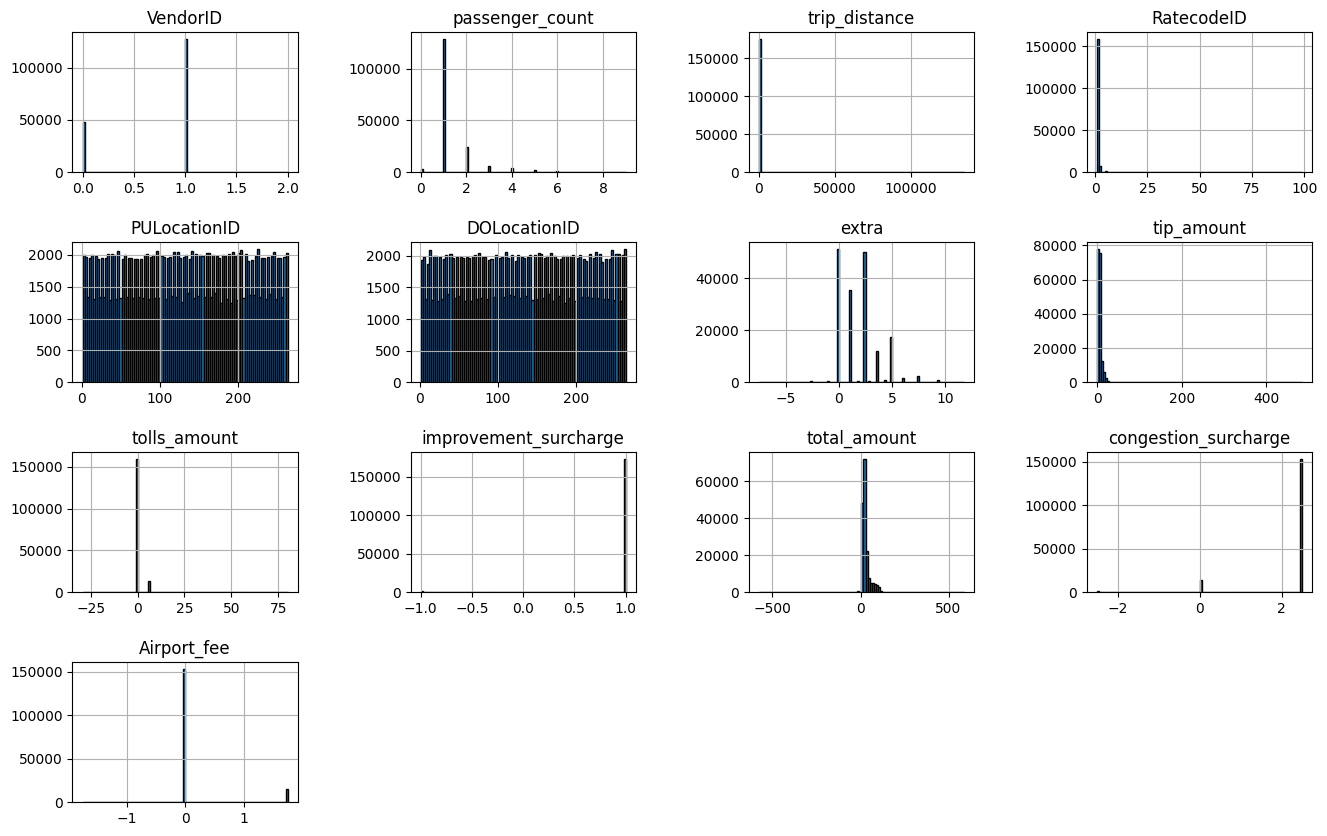

In [9]:
data.hist(bins = 100, edgecolor = 'black', figsize=(16,10))
plt.subplots_adjust(hspace = 0.5,wspace = 0.5)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


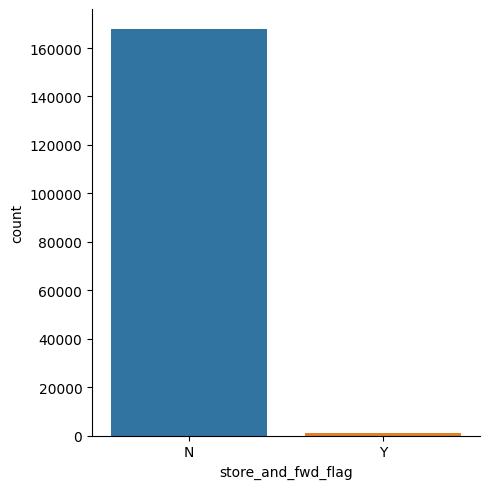

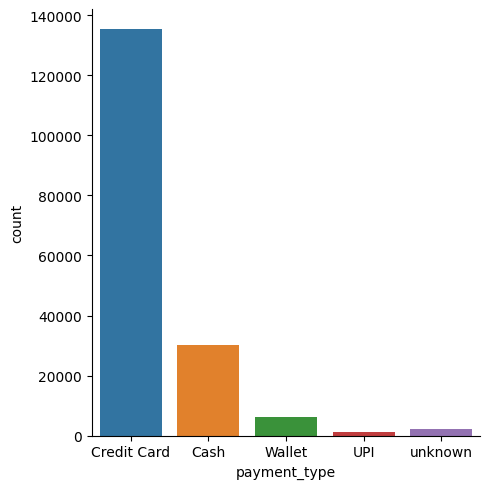

In [10]:
sns.catplot(data=X, x='store_and_fwd_flag', kind='count')
sns.catplot(data=X, x='payment_type', kind='count')

# **DATA PREPROCESSING**

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

df = pd.DataFrame(X)

# Convert string datetime columns to datetime objects
df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Calculate duration in minutes
df['duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60.0

# Extract time of the day (morning, afternoon, evening)
df['time_of_day'] = df['pickup_datetime'].apply(lambda x: 'morning' if 5 <= x.hour < 12 else 'afternoon' if 12 <= x.hour < 18 else 'evening')

# Extract day of the week
df['day_of_week'] = df['pickup_datetime'].dt.day_name()

# Use LabelEncoder for encoding categorical variables
label_encoder = LabelEncoder()
df['time_of_day_encoded'] = label_encoder.fit_transform(df['time_of_day'])
df['day_of_week_encoded'] = label_encoder.fit_transform(df['day_of_week'])

# Drop unnecessary columns
df = df.drop(['pickup_datetime', 'dropoff_datetime', 'time_of_day', 'day_of_week'], axis=1)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,duration,time_of_day_encoded,day_of_week_encoded
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,2.5,0.00,-45.600000,0,3
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,2.5,0.00,-63.433333,1,2
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,2.5,0.00,53.650000,2,0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,2.5,0.00,56.866667,0,2
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,2.5,0.00,18.833333,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174995,1,2023-06-30 22:50:57,2023-06-30 22:22:22,3.0,3.45,1.0,N,147,167,Credit Card,1.0,8.732495,0.0,1.0,2.5,0.00,-28.583333,1,0
174996,1,2023-06-30 13:03:33,2023-06-30 14:04:57,1.0,9.44,1.0,N,154,191,Cash,5.0,0.283275,0.0,1.0,2.5,1.75,61.400000,0,0
174997,0,2023-06-29 11:03:32,2023-06-29 12:13:34,1.0,2.40,1.0,N,168,106,Credit Card,2.5,4.245354,0.0,1.0,2.5,0.00,70.033333,2,2
174998,1,2023-06-29 19:47:17,2023-06-29 19:08:55,1.0,4.71,1.0,N,240,100,Credit Card,2.5,10.479776,0.0,1.0,2.5,0.00,-38.366667,1,2


In [12]:
transformer_list = [
    ('median', SimpleImputer(missing_values=np.nan,strategy= 'median'), ['passenger_count']),
    ('most_freq_1',SimpleImputer(missing_values=np.nan,strategy= 'most_frequent'),['store_and_fwd_flag']),
    ('mean_1',SimpleImputer(missing_values=np.nan,strategy= 'mean'), ['congestion_surcharge']),
    ('most_freq_2',SimpleImputer(missing_values=np.nan,strategy= 'most_frequent', ), ['RatecodeID']),
    ('mean_2',SimpleImputer(missing_values=np.nan,strategy= 'mean', ), ['Airport_fee'])
]

ct = ColumnTransformer(transformers = transformer_list, remainder='passthrough',verbose_feature_names_out=False)
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('median', SimpleImputer(strategy='median'),
                                 ['passenger_count']),
                                ('most_freq_1',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['store_and_fwd_flag']),
                                ('mean_1', SimpleImputer(),
                                 ['congestion_surcharge']),
                                ('most_freq_2',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['RatecodeID']),
                                ('mean_2', SimpleImputer(), ['Airport_fee'])],
                  verbose_feature_names_out=False)

The columns that have null values are being imputed. They are,
1. The null values in **'passenger_count'** is being imputed by the median value of its column, as it is a whole number.
2. The null values in **store_and_fwd_flag** is being imputed by the most frequent(mode) value of that column.
3. The null values in **congestion_surcharge** is being imputed by the mean of its column.
4. The null values in **RatecodeID** is being imputed by it's most frequent value.
5. The null values in **Airport_fee** is being imputed by it's mean value.

In [13]:
X = pd.DataFrame(ct.fit_transform(df),columns = ct.get_feature_names_out())

In [14]:
X[:1]

,passenger_count,store_and_fwd_flag,congestion_surcharge,RatecodeID,Airport_fee,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,duration,time_of_day_encoded,day_of_week_encoded
0,1.0,N,2.5,1.0,0.0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,2.14,120,9,Credit Card,2.5,7.165589,0.0,1.0,-45.6,0,3


In [15]:
X.shape

(175000, 19)

In [16]:
X = X.drop('tpep_pickup_datetime', axis=1)
X = X.drop('tpep_dropoff_datetime', axis=1)

In [17]:
X.shape

(175000, 17)

**Using OrdinalEncoder() to encode the categorical variables in the dataset.**

In [18]:
trf = [
    ("OE",OrdinalEncoder(),['store_and_fwd_flag', 'payment_type']),
]

ct2 = ColumnTransformer(trf, remainder='passthrough')

ct2

ColumnTransformer(remainder='passthrough',
                  transformers=[('OE', OrdinalEncoder(),
                                 ['store_and_fwd_flag', 'payment_type'])])

In [19]:
X_tr = ct2.fit_transform(X)
X_tr.shape

(175000, 17)

In [20]:
X_tr[:1]

array([[0.0, 1.0, 1.0, 2.5, 1.0, 0.0, 1, 2.14, 120, 9, 2.5,
        7.165588608107633, 0.0, 1.0, -45.6, 0, 3]], dtype=object)

**Correlation Matrix:** 
Correlation matrix represents the relationships between the variables in the dataset.
> NOTE: HERE THE DIAGONAL ELEMENTS ARE 1 AS THE VARIABLES WILL BE PREFECTLY CORRELATED WITH THEMSELVES.

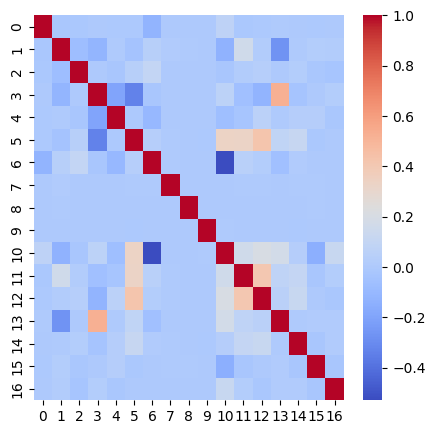

In [21]:
df = pd.DataFrame(X_tr)
corr_matrix = df.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [21]:
y = data['VendorID'].value_counts()
x1 = data[data['VendorID']==0]
vendor1 = sum(x1['total_amount'])/47597
x2 = data[data['VendorID']==1]
vendor2 = sum(x2['total_amount'])/127340
x3 = data[data['VendorID']==2]
vendor3 = sum(x3['total_amount'])/63
print(y)
print("vendor0 = ",vendor1)
print("vendor1 = ",vendor2)
print("vendor2 = ",vendor3)

VendorID
1    127340
0     47597
2        63
Name: count, dtype: int64
vendor0 =  28.004031136416756
vendor1 =  30.234272655879263
vendor2 =  47.50031746031746


In [ ]:
x = data.groupby("VendorID")
z = x.mean()
z

***Splitting the training dataset into training and validation set***

In [44]:
x_train, x_val, y_train, y_val = train_test_split(X_tr, y, test_size = 0.25, random_state=42)

# **MULTIPLE LINEAR REGRESSION**

In [45]:
lr = LinearRegression()
lr.fit(x_train,y_train)
lr_pred = lr.predict(x_val)
print("train=",lr.score(x_train,y_train))
mae = mean_absolute_error(y_val, lr_pred)
mse = mean_squared_error(y_val, lr_pred)
rmse = mean_squared_error(y_val, lr_pred, squared=False)
r2 = r2_score(y_val, lr_pred)

# Print the evaluation results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.10f}")

train= 0.7278980229341891
Mean Absolute Error (MAE): 7.93
Mean Squared Error (MSE): 183.15
Root Mean Squared Error (RMSE): 13.53
R-squared (R2) Score: 0.7175771804


**Pipeline class is used to combine the StandardScaler to scale the feature, PolynomialFeatures to generate polynomial features and the Linear Regression model.**

In [ ]:
# param_grid = {'poly__degree':list(range(1,4)),
#              'poly__interaction_only':[True,False]}
# lin_reg_pipeline = Pipeline([("feature", MinMaxScaler()),
#                              ("poly", PolynomialFeatures()),
#                             ("lin_reg", LinearRegression())])
# lr_grid_search = GridSearchCV(lin_reg_pipeline,
#                                  param_grid,
#                                  n_jobs=2,
#                                  cv=cv,
#                                  scoring="neg_mean_absolute_error",
#                                  return_train_score=True)
# lr_grid_search.fit(x_train, y_train)

In [ ]:
# lr_reg = lr_grid_search.best_estimator_
# best = lr_grid_search.best_params_
# print("Best parameters = ",best)
# print("Best estimator = ",lr_reg)

In [ ]:
# lr_reg.fit(x_train,y_train)
# print(lr_reg.score(x_train,y_train))
# lrpred = lr_reg.predict(x_val)
# print(r2_score(y_val,lrpred))

In [ ]:
# linear = Pipeline(steps=[('feature', StandardScaler()),
#                 ('poly', PolynomialFeatures(degree = 3,interaction_only=True)),
#                 ('lin_reg', LinearRegression())])
# linear.fit(x_train, y_train)
# train_score = linear.score(x_train,y_train)
# print ("Model performance on train set: ", train_score)
# lr_pred = linear.predict(x_val)
# mae = mean_absolute_error(y_val, lr_pred)
# mse = mean_squared_error(y_val, lr_pred)
# rmse = mean_squared_error(y_val, lr_pred, squared=False)
# r2 = r2_score(y_val, lr_pred)

# # Print the evaluation results
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R-squared (R2) Score: {r2:.10f}")

**Observations:**
1. When the data is trained with the **Linear Regression model without any hyper - parameter tuning, it gives a r2_score of 0.72319 on train data and 0.71283 on the validation data.**

2. On obtaining the best parameters and best estimators through hyper - parameter tuning using grid search, that is 
>   * Best estimator =  Pipeline(steps=[('feature', StandardScaler()), 
>                                   ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
>                                   ('lin_reg', LinearRegression())])

   the r2_score on the **train data is 0.86746** and **validation data is 0.87589**.
    
3. On trying it for degree 3 polynomial
>   * linear = Pipeline(steps=[('feature', StandardScaler()), 
>                              ('poly', PolynomialFeatures(degree = 3,interaction_only=True)),
>                              ('lin_reg', LinearRegression())])
                
   the r2_score on **train data 0.91646** and **validation data is 0.90646**. Hence, we can conclude that this is the good estimator for multiple linear regression model on this data.
                

# **SGD REGRESSOR**

In [ ]:
# sgd = Pipeline([('scaler', StandardScaler()),
#                  ('sgd', SGDRegressor(alpha=0.001, eta0=0.1, tol=1e-3, max_iter=10000))])
# sgd.fit(x_train,y_train)
# sgd_pred = sgd.predict(x_val)
# print("train=",sgd.score(x_train,y_train))
# mae = mean_absolute_error(y_val, sgd_pred)
# mse = mean_squared_error(y_val, sgd_pred)
# rmse = mean_squared_error(y_val, sgd_pred, squared=False)
# r2 = r2_score(y_val, sgd_pred)

# # Print the evaluation results
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R-squared (R2) Score: {r2:.10f}")

In [ ]:
# param_grid = {
#     'sgd__alpha': [0.0001, 0.001, 0.01],
#     'sgd__eta0': [0.01, 0.1]
# }
# sgd_reg_pipeline = Pipeline([("feature_scaling", MinMaxScaler()),
#                 ("Poly",PolynomialFeatures(degree=2, interaction_only=True)),
#                 ("sgd",SGDRegressor(learning_rate = 'adaptive', max_iter=10000, loss="squared_error", tol = 1e-3))])
# sgd_grid = GridSearchCV(sgd_reg_pipeline,
#                                  param_grid,
#                                  n_jobs=2,
#                                  cv=cv,
#                                  scoring="neg_mean_absolute_error",
#                                  return_train_score=True)

# sgd_grid.fit(x_train,y_train)

In [ ]:
# sgd_reg = sgd_grid.best_estimator_
# best = sgd_grid.best_params_
# print("Best parameters = ",best)
# print("Best estimator = ",sgd_reg)

In [ ]:
# train = sgd_reg.score(x_train,y_train)
# sgd_pred = sgd_reg.predict(x_val)
# mae = mean_absolute_error(y_val, sgd_pred)
# mse = mean_squared_error(y_val, sgd_pred)
# rmse = mean_squared_error(y_val, sgd_pred, squared=False)
# r2 = r2_score(y_val, sgd_pred)
# print("Train score = ",train)
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R-squared (R2) Score: {r2:.10f}")

**Observations:**
1. SGD regression without hyper parameter tuning gives us the negative scores, hence hyper parameter tuning is needed.
2. The best hyper parameters are
> * **Best parameters =  {'sgd__alpha': 0.0001, 'sgd__eta0': 0.1}**

    where, alpha is the regularization parameter and et0 is the initial learning rate
3. The best estimator is 
> * Best estimator =  Pipeline(steps=[('feature_scaling', MinMaxScaler()), 
                                   ('Poly', PolynomialFeatures(interaction_only=True)),
                                   ('sgd', SGDRegressor(eta0=0.1, learning_rate='adaptive', max_iter=100000, tol=0.0001))])
4. **The training score is a measure of how well the model fits the training data. In this case, it indicates that the model explains approximately 72.43% of the variance in the training data. An R-squared of 0.7075 suggests that approximately 70.75% of the variance in the target variable is explained by the model.**

# **k - NEIGHBOURS REGRESSOR**

In [ ]:
# k_range = list(range(1,21))
# params = dict(n_neighbors=k_range)
# print(params)

# reg_knn = KNeighborsRegressor()

# #validate model with his parameters
# gs = GridSearchCV(estimator=reg_knn, 
#                   param_grid=params, 
#                   cv=10, n_jobs=-1) 
# gs.fit(x_train, y_train)
# print("train = ", gs.score(x_train,y_train))
# print("test = ", r2_score(y_val,gs.predict(x_val)))
# reg_knn = gs.best_estimator_
# print(reg_knn) #printing best estimator values

In [ ]:
# knnpipe = Pipeline([('scaler', StandardScaler()),
#                  ('knn', KNeighborsRegressor(n_neighbors=3))])
# knnpipe.fit(x_train,y_train)
# knn_pred = knnpipe.predict(x_val)
# print("train = ", knnpipe.score(x_train,y_train))
# mae = mean_absolute_error(y_val, knn_pred)
# mse = mean_squared_error(y_val, knn_pred)
# rmse = mean_squared_error(y_val, knn_pred)
# r2 = r2_score(y_val, knn_pred)

# # Print the evaluation results
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R-squared (R2) Score: {r2:.10f}")

In [ ]:
# params = {'poly__degree':list(range(1,4)),
#           'poly__interaction_only':[True,False],
#           'knn__n_neighbors': list(range(2,4))}
# print(params)

# pipe1 = Pipeline(steps=[('scaler', StandardScaler()),
#                         ('poly', PolynomialFeatures()),
#                        ('knn', KNeighborsRegressor())])

# #validate model with his parameters
# gs1 = GridSearchCV(estimator=pipe1, 
#                   param_grid=params, 
#                   cv=cv, n_jobs=-1)

# gs1.fit(x_train, y_train)
# print("train=", gs1.score(x_train,y_train))

# best = gs1.best_params_
# reg_knn = gs1.best_estimator_

# # printing best estimator values
# print("Best parameters = ", best)
# print("Best estimators = ",reg_knn) 

In [ ]:
# gs_pred = gs1.predict(x_val)
# mae = mean_absolute_error(y_val, gs_pred)
# mse = mean_squared_error(y_val, gs_pred)
# rmse = mean_squared_error(y_val, gs_pred, squared=False)
# r2 = r2_score(y_val, gs_pred)

# # Print the evaluation results
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R-squared (R2) Score: {r2:.10f}")

**Observations:**
1. The K-nearest neighbors model with **n_neighbors=3** performs well on both **the training and validation sets**, achieving high R-squared scores of **0.9072 and 0.8081** respectively. 
2. The K-nearest neighbors model with a pipeline involving **standard scaling (StandardScaler) and n_neighbors=3** will give the R-squared scores of **0.8759 and 0.7415 on training and validation sets** repectively.
3. The grid search has identified the best hyperparameters for the pipeline, including setting n_neighbors to 3 for the K-neighbors regressor, using polynomial features with a degree of 2, and considering only interaction features 
> * Best parameters =  {'knn__n_neighbors': 3, 'poly__degree': 2, 'poly__interaction_only': True}
4. The best estimator is 
> * Best estimators =  Pipeline(steps=[('scaler', StandardScaler()),
                                    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
                                    ('knn', KNeighborsRegressor(n_neighbors=3))])

    with the R-squared scores of **0.8759 and 0.7415 on training and validation sets** repectively.

# **DECISION TREE REGRESSOR**

In [ ]:
# dt_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
#                              ("dt_reg", DecisionTreeRegressor(random_state = 42))])
# dt_reg_cv_results = cross_validate(dt_reg_pipeline,
#                                     X_tr,
#                                     y,
#                                     cv=cv,
#                                     scoring="r2",
#                                     return_train_score=True,
#                                     return_estimator=True)

# dt_reg_train_score =  dt_reg_cv_results['train_score']
# dt_reg_test_score = dt_reg_cv_results['test_score']

In [ ]:
# print(f"Score of decision tree regression model on the train set = "
#       f"{dt_reg_train_score.mean():.8f}")
# print(f"Score of decision tree regression model on the test set = "
#       f"{dt_reg_test_score.mean():.8f}")

In [ ]:
# param_grid = {'dt_reg__max_depth': range(1,20),
#               'dt_reg__min_samples_split':range(2,12)}
# dt_reg_pipeline1 = Pipeline([("feature_scaling", StandardScaler()),
#                              ("dt_reg", DecisionTreeRegressor(random_state = 42))])
# dt_grid_search = GridSearchCV(dt_reg_pipeline1,
#                                  param_grid=param_grid,
#                                  n_jobs=2,
#                                  cv=cv,
#                                  scoring="neg_mean_absolute_error",
#                                  return_train_score=True)
# dt_grid_search.fit(x_train, y_train)

In [ ]:
# mean_train_error = -1 * dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]
# mean_test_error = -1 * dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]
# std_train_error = dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]
# std_test_error = dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]

# print(f"Best Mean absolute error of decision tree regression model on the train set:\n"
#       f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
# print(f"Mean absolute error of decision tree regression model on the test set:\n"
#       f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

In [ ]:
# print ("The best parameter value is:", dt_grid_search.best_params_)

In [ ]:
# dt_reg_pipeline1.set_params(dt_reg__max_depth=14, dt_reg__min_samples_split=11).fit(x_train, y_train)

In [ ]:
# print("train = ",dt_reg_pipeline1.set_params(dt_reg__max_depth=14, dt_reg__min_samples_split=11).score(x_train, y_train))
# test_labels_pred = dt_reg_pipeline1.predict(x_val)
# mae = mean_absolute_error(y_val, test_labels_pred)
# mse = mean_squared_error(y_val, test_labels_pred)
# r2 = r2_score(y_val, test_labels_pred)

# print("The model performance for testing set")
# print("--------------------------------------")
# print('MAE is ', mae)
# print('MSE is ', mse)
# print('R2 score is ',r2)

**Observations:**
1. The Decision Tree Regressor without hyper parameter tuning will overfit on the dataset.
2. The Decision Tree Regression model, with the identified hyperparameters, demonstrates good performance on both the training and testing sets. The model generalizes well to unseen data, as evidenced by the consistent performance in cross-validation and the testing set. The R2 score of 0.940 on the testing set indicates that the model explains a substantial portion of the variance in the target variable.
  > **The best parameter value is: {'dt_reg__max_depth': 14, 'dt_reg__min_samples_split': 11}**
  
    The R - squared scores are **0.96675 and 0.93999 on train data and validation data** respectively.

# **RANDOM FOREST REGRESSION**

In [ ]:
# def train_regressor(estimator, X_train, y_train, cv, name):
#   cv_results = cross_validate(estimator,
#                               X_train,
#                               y_train,
#                               cv=cv,
#                               scoring="neg_mean_absolute_error",
#                               return_train_score=True,
#                               return_estimator=True)

#   cv_train_error = -1* cv_results['train_score']
#   cv_test_error = -1 * cv_results['test_score']

#   print(f"On an average, {name} makes an error of "
#         f"{cv_train_error.mean():.3f}k +/- {cv_train_error.std():.3f}k on the training set.")
#   print(f"On an average, {name} makes an error of "
#         f"{cv_test_error.mean():.3f}k +/- {cv_test_error.std():.3f}k on the test set.")

In [ ]:
# train_regressor(
#     BaggingRegressor(), x_train, y_train, cv, 'bagging regressor')

In [ ]:
# train_regressor(
#     RandomForestRegressor(), x_train, y_train, cv, 'random forest regressor')

In [ ]:
# br = BaggingRegressor()
# br.fit(x_train,y_train)
# print("train = ",br.score(x_train,y_train))
# print("r2_score = ",r2_score(y_val,br.predict(x_val)))

In [ ]:
# rf = Pipeline([("feature_scaling", MinMaxScaler()),
#                 ('rf', RandomForestRegressor())])
# rf.fit(x_train,y_train)
# rf_pred = rf.predict(x_val)
# print("train=",rf.score(x_train,y_train))
# mae = mean_absolute_error(y_val, rf_pred)
# mse = mean_squared_error(y_val, rf_pred)
# rmse = mean_squared_error(y_val, rf_pred, squared=False)
# r2 = r2_score(y_val, rf_pred)

# # Print the evaluation results
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R-squared (R2) Score: {r2:.2f}")

In [ ]:
# param_grid = {"rf__n_estimators": [100, 200, 500, 800],
#     "rf__max_leaf_nodes": [100, 150, 200]}

# pipe3=Pipeline([("feature_scaling", StandardScaler()),
#                ("rf", RandomForestRegressor())])

# search_cv = GridSearchCV(pipe3,
#                         param_grid=param_grid,
#                         n_jobs=2,
#                         cv=cv,
#                         scoring="neg_mean_absolute_error",
#                         return_train_score=True)
# search_cv.fit(x_train, y_train)


# columns = [f"param_{name}" for name in param_grid.keys()]
# columns += ["mean_test_error", "std_test_error"]
# cv_results = pd.DataFrame(search_cv.cv_results_)
# cv_results["mean_test_error"] = -cv_results["mean_test_score"]
# cv_results["std_test_error"] = cv_results["std_test_score"]
# cv_results[columns].sort_values(by="mean_test_error")

In [ ]:
# pipe3=Pipeline([("feature_scaling", StandardScaler()),
#                ("rf", RandomForestRegressor(n_estimators=800, max_leaf_nodes=200, random_state=42))])

# pipe3.fit(x_train,y_train)
# print("train = ", pipe3.score(x_train, y_train))
# rf_regr_pred = pipe3.predict(x_val)
# print("mae = ",mean_absolute_error(y_val, rf_regr_pred))
# print("mse = ", mean_squared_error(y_val, rf_regr_pred))
# print("rmse = ", mean_squared_error(y_val, rf_regr_pred))
# print("test = ", r2_score(y_val,rf_regr_pred))

**Observations:**
* **Without hyper parameter tuning**
1. Both models (Bagging Regressor and Random Forest Regressor) exhibit low errors on the training set, indicating good fitting to the training data. Random Forest Regressor has a slightly lower average error on the training set compared to Bagging Regressor (1.052 vs. 1.177)
2. Random Forest Regressor tends to have lower errors on average, suggesting better generalization to unseen data.
3. **The R - squared scores are 0.99 and 0.95 on training and validation data respectively**.

* **With hyper parameter tuning**
1. The best estimator is 
> * Pipeline([("feature_scaling", StandardScaler()),
                ("rf", RandomForestRegressor(n_estimators=800, max_leaf_nodes=200, random_state=42))])
                
    **The R - squared scores are 0.9613 and 0.9458 on training and validation data respectively**.           

# Performance of different models with and without hyperparameter tuning

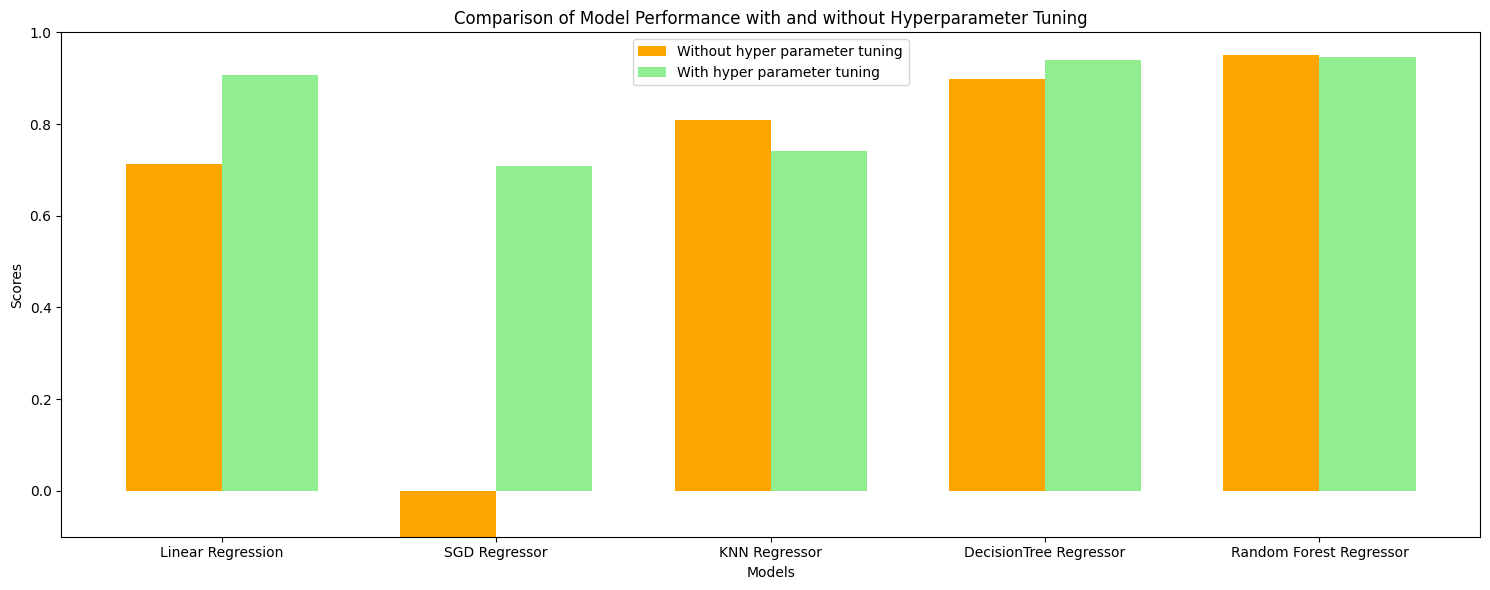

In [46]:
# Data for models without hyperparameter tuning
model_names = ['Linear Regression', 'SGD Regressor', 'KNN Regressor', 'DecisionTree Regressor', 'Random Forest Regressor']
model_scores_without_tuning = [0.7128, -8, 0.8081, 0.8981, 0.9504]

# Data for models with hyperparameter tuning
model_scores_with_tuning = [0.9065, 0.7075, 0.7416, 0.9399, 0.9458]

# Set up positions for the bars
bar_width = 0.35
index = np.arange(len(model_names))

# Plot the clustered bar chart
plt.figure(figsize=(15, 6))
bar1 = plt.bar(index, model_scores_without_tuning, bar_width, label='Without hyper parameter tuning', color='orange')
bar2 = plt.bar(index + bar_width, model_scores_with_tuning, bar_width, label='With hyper parameter tuning', color='lightgreen')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance with and without Hyperparameter Tuning')
plt.ylim(-0.1, 1)
plt.xticks(index + bar_width / 2, model_names, rotation=0)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

# Define individual regressor models
regressor1 = RandomForestRegressor()
regressor2 = GradientBoostingRegressor()
regressor3 = ExtraTreesRegressor()

# Create a voting regressor with the individual models
voting_regressor = VotingRegressor(estimators=[
    ('linear', regressor1),
    ('tree', regressor2),
    ('bg', regressor3),
])

# Train the voting regressor
voting_regressor.fit(x_train, y_train)

print("train = ",voting_regressor.score(x_train, y_train))
regr_pred = voting_regressor.predict(x_val)
print("mae = ",mean_absolute_error(y_val, regr_pred))
print("mse = ", mean_squared_error(y_val, regr_pred))
print("rmse = ", mean_squared_error(y_val, regr_pred))
print("test = ", r2_score(y_val,regr_pred))

train =  0.9886917688882241
mae =  2.652696044238058
mse =  30.85455456135183
rmse =  30.85455456135183
test =  0.9524206169367974


# **TEST DATA**

In [ ]:
test = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')
test

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

df = pd.DataFrame(test)

# Convert string datetime columns to datetime objects
df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Calculate duration in minutes
df['duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60.0

# Extract time of the day (morning, afternoon, evening)
df['time_of_day'] = df['pickup_datetime'].apply(lambda x: 'morning' if 5 <= x.hour < 12 else 'afternoon' if 12 <= x.hour < 18 else 'evening')

# Extract day of the week
df['day_of_week'] = df['pickup_datetime'].dt.day_name()

# Use LabelEncoder for encoding categorical variables
label_encoder = LabelEncoder()
df['time_of_day_encoded'] = label_encoder.fit_transform(df['time_of_day'])
df['day_of_week_encoded'] = label_encoder.fit_transform(df['day_of_week'])

# Drop unnecessary columns
df = df.drop(['pickup_datetime', 'dropoff_datetime', 'time_of_day', 'day_of_week'], axis=1)
df

In [ ]:
test = pd.DataFrame(ct.fit_transform(df),columns = ct.get_feature_names_out())

In [ ]:
test = test.drop('tpep_pickup_datetime', axis=1)
test = test.drop('tpep_dropoff_datetime', axis=1)

In [ ]:
test = ct2.fit_transform(test)

In [ ]:
test.shape

In [ ]:
y_pred = voting_regressor.predict(test)

In [ ]:
submission = pd.DataFrame(columns = ["ID","total_amount"])
submission["ID"] = [i for i in range(1, len(y_pred)+1)]
submission["total_amount"] = y_pred
submission.to_csv('submission.csv', index = False)